In [10]:
!pip install setuptools


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
from urllib.parse import urlparse

# Load the dataset
df = pd.read_csv('urldata.csv')

# Inspect data
df.sample(100)


,Unnamed: 0,url,label,result
228487,228487,https://www.ladiesofthecanyon.com/,benign,0
102557,102557,https://www.streamsportonline.com/detroit-tige...,benign,0
216773,216773,https://www.imdb.com/name/nm0122572/,benign,0
240404,240404,https://www.magnumpsyche.com/leading-sire/2009...,benign,0
29547,29547,https://www.en.wikipedia.org/wiki/A_Benefit_fo...,benign,0
...,...,...,...,...
7553,7553,https://www.bessel.org/cwgfunio.htm,benign,0
54677,54677,https://www.harmonmeek.com/artists/jenkins.html,benign,0
110343,110343,https://www.twitter.com/erin_moran,benign,0
292448,292448,https://www.songlyrics.com/george-strait/any-o...,benign,0


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate, Input, Embedding, GRU, Dense
from tensorflow.keras.optimizers import Adam

# Step 1: Prepare the data (0 for benign, 1 for phishing)

# Tokenize the URLs (character-level tokenization)
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(df['url'])

# Convert the URLs into sequences of integers
url_sequences = tokenizer.texts_to_sequences(df['url'])

# Pad the sequences to make them of equal length
max_sequence_length = 100  # can be adjusted based on data
X = pad_sequences(url_sequences, maxlen=max_sequence_length)

# Target labels
y = df['result'].values

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Build the GRU model
vocab_size = len(tokenizer.word_index) + 1  # Total number of unique characters
embedding_dim = 50  # Size of the character embedding vectors

model = Sequential()

# Embedding layer (convert each character to a dense vector)
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

# GRU layer
model.add(GRU(128, return_sequences=False))

# Output layer (binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Step 4: Train the model
model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test))

# Step 5: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')


C:\Users\tyler\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
2814/2814 ━━━━━━━━━━━━━━━━━━━━ 171s 60ms/step - accuracy: 0.9396 - loss: 0.1609 - val_accuracy: 0.9927 - val_loss: 0.0253
Epoch 2/5
2814/2814 ━━━━━━━━━━━━━━━━━━━━ 168s 60ms/step - accuracy: 0.9937 - loss: 0.0223 - val_accuracy: 0.9937 - val_loss: 0.0223
Epoch 3/5
2814/2814 ━━━━━━━━━━━━━━━━━━━━ 164s 58ms/step - accuracy: 0.9949 - loss: 0.0182 - val_accuracy: 0.9950 - val_loss: 0.0178
Epoch 4/5
2814/2814 ━━━━━━━━━━━━━━━━━━━━ 166s 59ms/step - accuracy: 0.9957 - loss: 0.0159 - val_accuracy: 0.9958 - val_loss: 0.0152
Epoch 5/5
2814/2814 ━━━━━━━━━━━━━━━━━━━━ 164s 58ms/step - accuracy: 0.9965 - loss: 0.0129 - val_accuracy: 0.9961 - val_loss: 0.0143
2814/2814 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9962 - loss: 0.0148
Test Accuracy: 0.9960793256759644


In [3]:
# Save the trained GRU model
model.save('webapp_backend/model/phishing_gru_model.keras')

# Save the tokenizer using pickle
import pickle

with open('webapp_backend/model/gru_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


In [4]:
# Import required modules
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Load the saved GRU model in .keras format
model = load_model('webapp_backend/model/phishing_gru_model.keras')

# Example usage: Tokenizing a new URL
MAX_SEQUENCE_LENGTH = 100  # Same value used during training

In [5]:
from sklearn.metrics import roc_curve

# Example: Get prediction probabilities for a test dataset
y_prob = model.predict(X_test).flatten()

# Compute ROC curve and find the optimal threshold
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
optimal_idx = (tpr - fpr).argmax()  # Maximize TPR - FPR
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")

# Use the new threshold in predictions
prediction = 'phishing' if y_prob[0] >= optimal_threshold else 'benign'
print(f"Prediction: {prediction} , {y_prob[0]}")


2814/2814 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step
Optimal Threshold: 0.1532408595085144
Prediction: phishing , 0.9999924302101135


In [8]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
history = model.fit(
    X_train, y_train, 
    validation_split=0.2,  # Use 20% of the training data for validation
    epochs=10, 
    batch_size=32
)


Epoch 1/10
9004/9004 ━━━━━━━━━━━━━━━━━━━━ 206s 23ms/step - accuracy: 0.9963 - loss: 0.0135 - val_accuracy: 0.9964 - val_loss: 0.0131
Epoch 2/10
9004/9004 ━━━━━━━━━━━━━━━━━━━━ 206s 23ms/step - accuracy: 0.9968 - loss: 0.0111 - val_accuracy: 0.9970 - val_loss: 0.0119
Epoch 3/10
9004/9004 ━━━━━━━━━━━━━━━━━━━━ 209s 23ms/step - accuracy: 0.9975 - loss: 0.0090 - val_accuracy: 0.9971 - val_loss: 0.0115
Epoch 4/10
9004/9004 ━━━━━━━━━━━━━━━━━━━━ 208s 23ms/step - accuracy: 0.9979 - loss: 0.0081 - val_accuracy: 0.9968 - val_loss: 0.0125
Epoch 5/10
9004/9004 ━━━━━━━━━━━━━━━━━━━━ 206s 23ms/step - accuracy: 0.9981 - loss: 0.0071 - val_accuracy: 0.9974 - val_loss: 0.0117
Epoch 6/10
9004/9004 ━━━━━━━━━━━━━━━━━━━━ 206s 23ms/step - accuracy: 0.9982 - loss: 0.0067 - val_accuracy: 0.9971 - val_loss: 0.0122
Epoch 7/10
9004/9004 ━━━━━━━━━━━━━━━━━━━━ 209s 23ms/step - accuracy: 0.9984 - loss: 0.0063 - val_accuracy: 0.9970 - val_loss: 0.0133
Epoch 8/10
9004/9004 ━━━━━━━━━━━━━━━━━━━━ 210s 23ms/step - accuracy: 

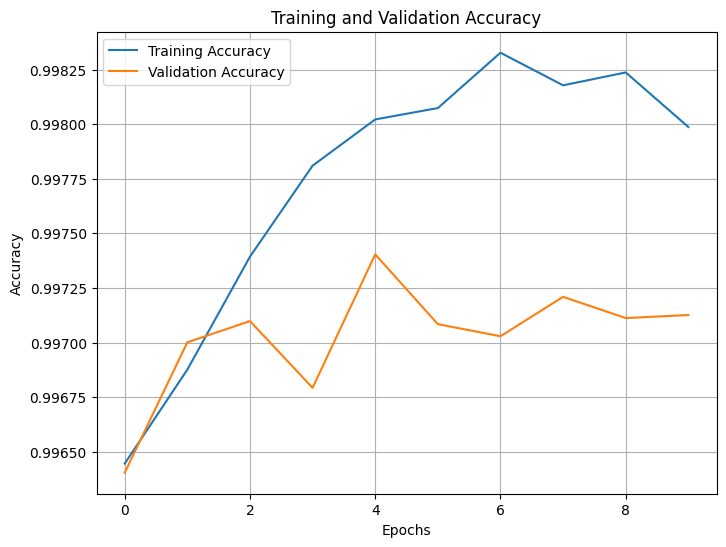

In [9]:


def plot_training_history(history):
    plt.figure(figsize=(8, 6))
    
    # Plot the accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    
    # Add labels and legend
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage: assuming you have a 'history' object
plot_training_history(history)



2814/2814 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step


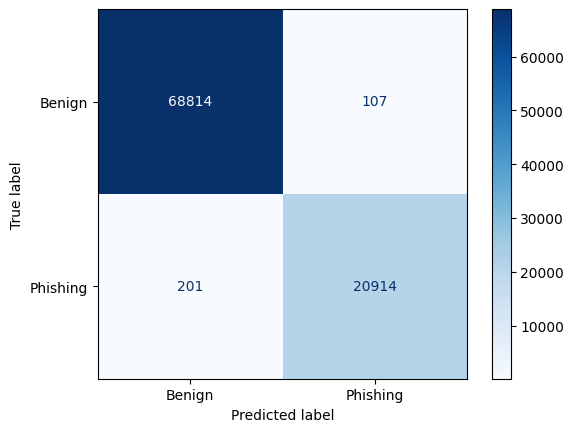

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# step 1: make predictions on test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# step 2: gererate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# step 3: display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign","Phishing"])
disp.plot(cmap="Blues", values_format='d')

Epoch 1/10
9004/9004 ━━━━━━━━━━━━━━━━━━━━ 209s 23ms/step - accuracy: 0.9983 - loss: 0.0064 - val_accuracy: 0.9969 - val_loss: 0.0131
Epoch 2/10
9004/9004 ━━━━━━━━━━━━━━━━━━━━ 209s 23ms/step - accuracy: 0.9983 - loss: 0.0063 - val_accuracy: 0.9967 - val_loss: 0.0130
Epoch 3/10
9004/9004 ━━━━━━━━━━━━━━━━━━━━ 207s 23ms/step - accuracy: 0.9982 - loss: 0.0066 - val_accuracy: 0.9967 - val_loss: 0.0138
Epoch 4/10
9004/9004 ━━━━━━━━━━━━━━━━━━━━ 204s 23ms/step - accuracy: 0.9979 - loss: 0.0074 - val_accuracy: 0.9966 - val_loss: 0.0143
Epoch 5/10
9004/9004 ━━━━━━━━━━━━━━━━━━━━ 204s 23ms/step - accuracy: 0.9975 - loss: 0.0086 - val_accuracy: 0.9967 - val_loss: 0.0128
Epoch 6/10
9004/9004 ━━━━━━━━━━━━━━━━━━━━ 203s 23ms/step - accuracy: 0.9975 - loss: 0.0084 - val_accuracy: 0.9969 - val_loss: 0.0126
Epoch 7/10
9004/9004 ━━━━━━━━━━━━━━━━━━━━ 203s 23ms/step - accuracy: 0.9975 - loss: 0.0084 - val_accuracy: 0.9964 - val_loss: 0.0134
Epoch 8/10
9004/9004 ━━━━━━━━━━━━━━━━━━━━ 202s 22ms/step - accuracy: 

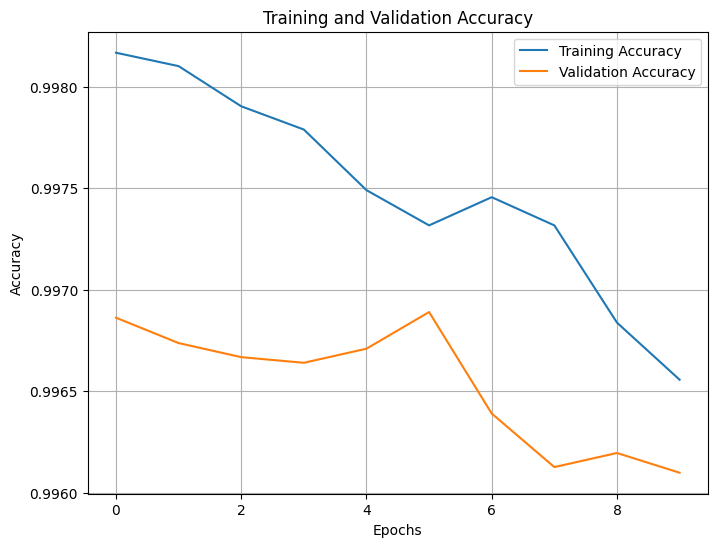

In [11]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
history = model.fit(
    X_train, y_train, 
    validation_split=0.2,  # Use 20% of the training data for validation
    epochs=10, 
    batch_size=32
)

def plot_training_history(history):
    plt.figure(figsize=(8, 6))
    
    # Plot the accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    
    # Add labels and legend
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage: assuming you have a 'history' object
plot_training_history(history)
